In [141]:
import pandas as pd
import numpy as np
from glob import glob
from scipy import stats
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes
import random
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
from transformer_lens import HookedTransformer
import torch
from jaxtyping import Float, Int
from collections import defaultdict, Counter
from sklearn.decomposition import TruncatedSVD
import json
import itertools
from scipy.stats import linregress
import plotly_express as px
from torch.distributions.multivariate_normal import MultivariateNormal
import torch.nn.functional as F
import math
import seaborn as sns
from scipy.signal import savgol_filter

from collections.abc import Callable
import numpy as np
import torch
from datasets import Dataset, load_dataset
from typing import Optional, Tuple
from abc import ABC, abstractmethod
from dataclasses import dataclass
from typing import final, cast
import gc
from scipy.stats import kstest

## Setup

In [3]:
def clean_cache():
    torch.cuda.empty_cache()
    gc.collect()


def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


def get_device_str() -> str:
    if torch.backends.mps.is_available():
        return "mps"
    else:
        return "cuda" if torch.cuda.is_available() else "cpu"


# Utils
def generate_prompt(dataset, n_ctx: int = 1, batch: int = 1) -> torch.Tensor:
    """Generate a prompt from the dataset."""
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch, shuffle=True)
    return next(iter(dataloader))["input_ids"][:, :n_ctx]


def compute_kl_div(logits_ref: torch.Tensor, logits_pert: torch.Tensor) -> torch.Tensor:
    """Compute the KL divergence between the reference and perturbed logprobs."""
    logprobs_ref = F.log_softmax(logits_ref, dim=-1)
    logprobs_pert = F.log_softmax(logits_pert, dim=-1)
    temp_output = F.kl_div(
        logprobs_ref, logprobs_pert, log_target=True, reduction="none"
    )
    return temp_output.sum(dim=-1)


def get_random_activation(
    model: HookedTransformer, dataset: Dataset, n_ctx: int, layer: str, pos
) -> torch.Tensor:
    """Get a random activation from the dataset."""
    rand_prompt = generate_prompt(dataset, n_ctx=n_ctx)
    _, cache = model.run_with_cache(rand_prompt)
    return cache[layer][:, pos, :].to("cpu").detach()


def load_pretokenized_dataset(
    path: str,
    split: str,
) -> Dataset:
    dataset = load_dataset(path, split=split)
    dataset = cast(Dataset, dataset)
    return dataset.with_format("torch")


def get_random_activations(
    model: HookedTransformer, dataset: Dataset, n_ctx: int, layer: str, pos, n_samples
) -> torch.Tensor:
    """Get a random activation from the dataset."""
    rand_prompts = torch.cat(
        [generate_prompt(dataset, n_ctx=n_ctx) for _ in range(n_samples)]
    )
    _, cache = model.run_with_cache(rand_prompts)
    return cache[layer][:, pos, :].to("cpu").detach()


def cosine_similarity(a, b):
    return F.cosine_similarity(a.unsqueeze(0), b.unsqueeze(0)).item()

In [4]:
@dataclass
class ExperimentConfig:
    n_ctx: int
    perturbation_layer: str
    read_layer: str
    perturbation_pos: slice
    n_steps: int
    perturbation_range: Tuple[float, float]
    seed: Optional[int] = None
    dataloader_batch_size: Optional[int] = None
    mean_batch_size: Optional[int] = None


class Reference:
    def __init__(
        self,
        model: HookedTransformer,
        prompt: torch.Tensor,
        perturbation_layer: str,
        read_layer: str,
        perturbation_pos: slice,
        n_ctx: int,
    ):
        self.model = model
        _, n_ctx_prompt = prompt.shape
        assert (
            n_ctx == n_ctx_prompt
        ), f"n_ctx {n_ctx} must match prompt n_ctx {n_ctx_prompt}"
        self.prompt = prompt
        logits, cache = model.run_with_cache(prompt)
        self.logits = logits.to("cpu").detach()
        self.cache = cache.to("cpu")
        self.act = self.cache[perturbation_layer][:, perturbation_pos]
        self.perturbation_layer = perturbation_layer
        self.read_layer = read_layer
        self.perturbation_pos = perturbation_pos
        self.n_ctx = n_ctx

In [8]:
cfg = ExperimentConfig(
    n_ctx=10,
    perturbation_layer="blocks.1.hook_resid_pre",
    seed=7654,
    dataloader_batch_size=15,
    perturbation_pos=slice(-1, None, 1),
    read_layer="blocks.11.hook_resid_post",
    perturbation_range=(0, 1),
    n_steps=100,
    mean_batch_size=512,
)

In [9]:
set_seed(cfg.seed)

In [10]:
dataset = load_pretokenized_dataset(
    path="apollo-research/Skylion007-openwebtext-tokenizer-gpt2", split="train"
)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=cfg.dataloader_batch_size, shuffle=True
)

Resolving data files:   0%|          | 0/73 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/73 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/75 [00:00<?, ?it/s]

In [11]:
model = HookedTransformer.from_pretrained("gpt2")
device = get_device_str()

print(device)

Loaded pretrained model gpt2 into HookedTransformer
cuda


In [12]:
saes, sparsities = get_gpt2_res_jb_saes(cfg.perturbation_layer)
sae = saes[cfg.perturbation_layer].cpu()
feature_sparsities = 10 ** sparsities[cfg.perturbation_layer].cpu()

sae.eval()

100%|██████████| 1/1 [00:00<00:00,  1.77it/s]


SAE(
  (activation_fn): ReLU()
  (hook_sae_input): HookPoint()
  (hook_sae_acts_pre): HookPoint()
  (hook_sae_acts_post): HookPoint()
  (hook_sae_output): HookPoint()
  (hook_sae_recons): HookPoint()
  (hook_sae_error): HookPoint()
)

## Replication

### Other act vs random

In [18]:
def load_jsonl(file_path):
    data = []
    with open(file_path, "r") as file:
        for line in file:
            # Parse each line as a JSON object
            json_object = json.loads(line.strip())
            data.append(json_object)
    return data


def find_blowup_max_slope(dists: List[float], min_slope_threshold: float = 0.02):
    steps = list(range(len(dists)))

    slopes = []
    for i in range(1, len(steps)):
        dy = dists[i] - dists[i - 1]
        dx = steps[i] - steps[i - 1]
        slopes.append(dy / dx if dx != 0 else 0)

    # Pad the beginning of slopes list to match the length of steps
    slopes = [slopes[0]] + slopes

    if not any(np.array(slopes) > min_slope_threshold):
        return len(steps) - 1

    return np.argsort(np.nan_to_num(slopes))[::-1][0]

In [10]:
results = {"other_act": {"l2": [], "ms": []}, "random": {"l2": [], "ms": []}}

In [15]:
metadata, activations = [], []

pert_type = "random"
n_files = 5

for path in sorted(glob(f"replications/{pert_type}_metadata*"))[:n_files]:
    metadata.extend(load_jsonl(path))

for path in sorted(glob(f"replications/{pert_type}_acts*"))[:n_files]:
    activations.append(np.load(path))

activations = np.concatenate(activations)

In [16]:
for idx, m in enumerate(metadata):
    steps = m["steps_metadata"]
    pert_l2 = [s["read_layer_l2_norm"] for s in steps]
    results[pert_type]["l2"].extend(pert_l2)
    ms = find_blowup_max_slope(pert_l2)
    results[pert_type]["ms"].append(ms)

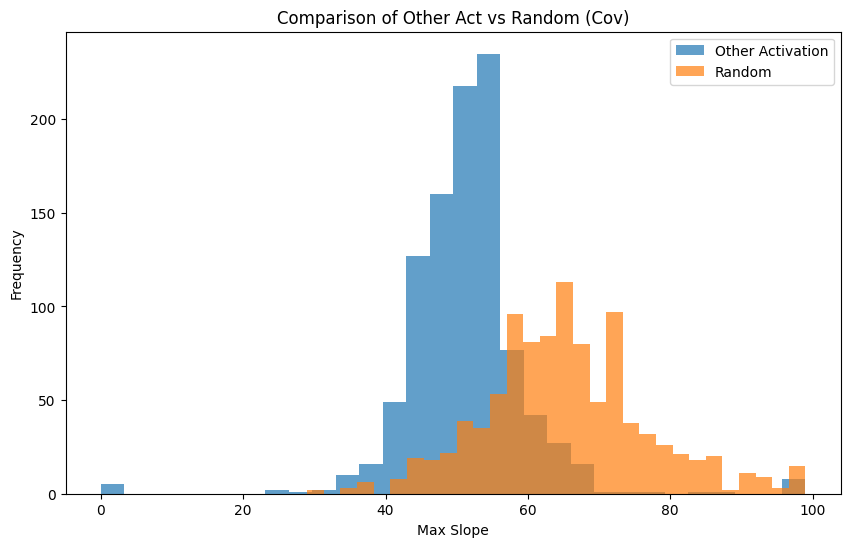

In [17]:
# Create the plot
plt.figure(figsize=(10, 6))

# Plot both histograms
plt.hist(results["other_act"]["ms"], bins=30, alpha=0.7, label="Other Activation")
plt.hist(results["random"]["ms"], bins=30, alpha=0.7, label="Random")

# Customize the plot
plt.xlabel("Max Slope")
plt.ylabel("Frequency")
plt.title("Comparison of Other Act vs Random (Cov)")
plt.legend()

# Show the plot
plt.show()

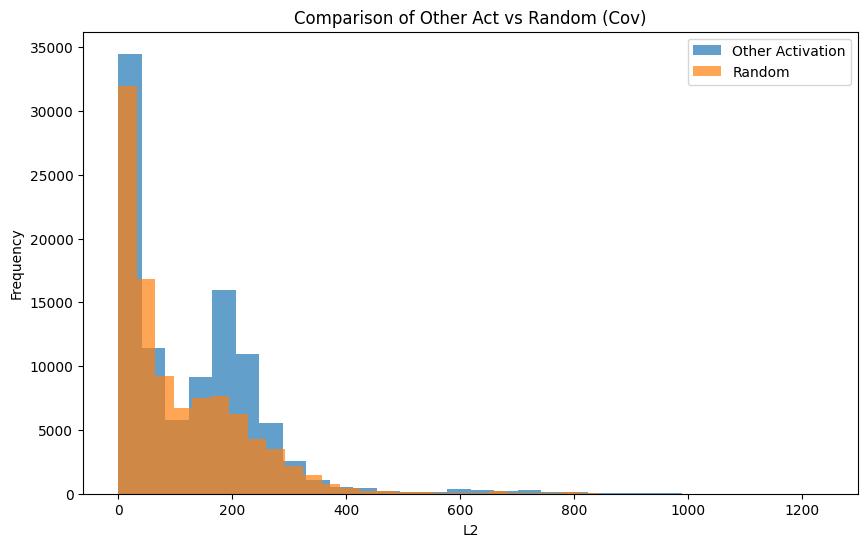

In [22]:
# Create the plot
plt.figure(figsize=(10, 6))

# Plot both histograms
plt.hist(results["other_act"]["l2"], bins=30, alpha=0.7, label="Other Activation")
plt.hist(results["random"]["l2"], bins=30, alpha=0.7, label="Random")

# Customize the plot
plt.xlabel("L2")
plt.ylabel("Frequency")
plt.title("Comparison of Other Act vs Random (Cov)")
plt.legend()

# Show the plot
plt.show()

In [20]:
kstest(results["other_act"]["ms"], results["random"]["ms"])

KstestResult(statistic=0.635, pvalue=1.1875381285669299e-189, statistic_location=57, statistic_sign=1)

In [21]:
kstest(results["other_act"]["l2"], results["random"]["l2"])

KstestResult(statistic=0.12663999999999997, pvalue=0.0, statistic_location=152.1401, statistic_sign=-1)

### Real vs Synthetic

In [181]:
def perturb_activation(start_act, end_act, num_steps=100):
    device = start_act.device
    t = torch.linspace(0, 1, num_steps, device=device).unsqueeze(1)
    return start_act * (1 - t) + end_act * t


def perturb_activation_norm_step_size(
    start_act, end_act, step_size=0.01, num_steps=100
):
    device = start_act.device
    dir = end_act - start_act
    t = torch.linspace(1, num_steps, num_steps, device=device).unsqueeze(1)
    return dir * t * step_size


def run_with_perturbation(cfg, model, prompt, perturbed_acts):
    def hook(act, hook):
        act[:, -1, :] = perturbed_acts

    prompts = prompt.repeat(perturbed_acts.shape[0], 1)

    with model.hooks(fwd_hooks=[(cfg.perturbation_layer, hook)]):
        logits_pert, cache = model.run_with_cache(prompts)

    return logits_pert, cache


def setup_random_sampling_data_cov():
    data_mean = torch.tensor(np.load("observations_layer1/data_mean.npy"))
    data_cov = torch.tensor(np.load("observations_layer1/data_cov.npy"))
    distrib = MultivariateNormal(data_mean, data_cov)
    return distrib


def get_random_acts(distrib, k=1):
    return distrib.sample([k])

In [72]:
non_dead_feat_ids = np.where(sparsities[cfg.perturbation_layer].cpu().numpy() > -10)[0]

In [74]:
norms = []

for acts in activations:
    norms.append(sae.encode(torch.tensor(acts[0])).norm().item())

mean_norm_sae = np.mean(norms)
print(mean_norm_sae)

25.772254322052003


In [142]:
distrib = setup_random_sampling_data_cov()

In [19]:
metadata, activations = [], []

pert_type = "other_act"
n_files = 5

for path in sorted(glob(f"replications/{pert_type}_metadata*"))[:n_files]:
    metadata.extend(load_jsonl(path))

for path in sorted(glob(f"replications/{pert_type}_acts*"))[:n_files]:
    activations.append(np.load(path))

activations = np.concatenate(activations)

In [192]:
l2_synth = []
l2_other = []
l2_random = []

In [193]:
idxs = random.sample(range(len(metadata)), 25)

for idx in idxs:
    m = metadata[idx]
    acts = activations[idx]
    steps = m["steps_metadata"]
    prompt = torch.tensor(m["start_prompt"])
    start_act = torch.tensor(acts[0])

    # Synthetic as T
    random_feat_id = random.choice(non_dead_feat_ids)

    feat_acts = torch.zeros(sae.W_dec.shape[0])
    feat_acts[random_feat_id] = mean_norm_sae
    end_act = sae.decode(feat_acts)

    # perturbed_acts = perturb_activation(start_act, end_act)
    perturbed_acts = perturb_activation_norm_step_size(
        start_act, end_act, step_size=0.01
    )
    pert_logits, cache = run_with_perturbation(cfg, model, prompt, perturbed_acts)

    read_layer_l2_norms = (
        torch.norm(
            cache[cfg.read_layer][:, -1, :] - cache[cfg.read_layer][0, -1, :],
            dim=1,
        )
        .detach()
        .cpu()
    )
    l2_synth.append(read_layer_l2_norms)

    # --------------------------------------------------------------------------

    # Other Act as T
    l2_other.append([s["read_layer_l2_norm"] for s in steps])

    # --------------------------------------------------------------------------

    # Random as T
    end_act = get_random_acts(distrib).squeeze(0)
    perturbed_acts = perturb_activation(start_act, end_act)
    pert_logits, cache = run_with_perturbation(cfg, model, prompt, perturbed_acts)

    read_layer_l2_norms = (
        torch.norm(
            cache[cfg.read_layer][:, -1, :] - cache[cfg.read_layer][0, -1, :],
            dim=1,
        )
        .detach()
        .cpu()
    )
    l2_random.append(read_layer_l2_norms)

    # --------------------------------------------------------------------------

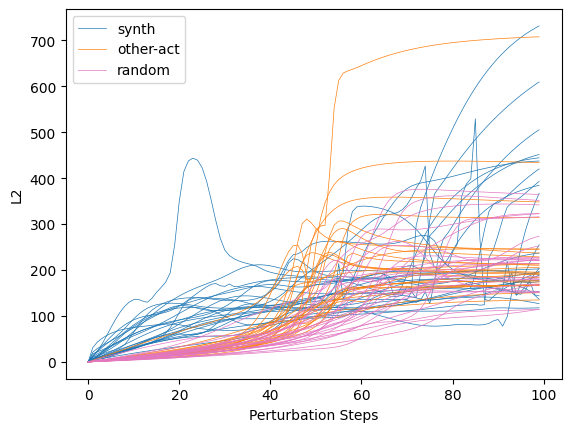

In [194]:
for i, l2 in enumerate(l2_synth):
    label = None if i > 0 else "synth"
    plt.plot(l2, color="tab:blue", label=label, linewidth=0.5)

for i, l2 in enumerate(l2_other):
    label = None if i > 0 else "other-act"
    plt.plot(l2, color="tab:orange", label=label, linewidth=0.5)

for i, l2 in enumerate(l2_random):
    label = None if i > 0 else "random"
    plt.plot(l2, color="tab:pink", label=label, linewidth=0.5)

plt.xlabel("Perturbation Steps")
plt.ylabel("L2")
plt.legend()
plt.show()